In [ ]:
!pip install bayesflow

In [168]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import bayesflow as bf

In [169]:
# Suppress scientific notation for floats
np.set_printoptions(suppress=True)
try:
    from numba import njit
except ModuleNotFoundError as err:
    print

In [170]:
RNG = np.random.default_rng(2023)

## Simulator

In [175]:
@njit
def simulator2DD(params, n_object = 10, max_iter=1e5,dt=1e-3):
    mu = np.zeros(2)
    a,mu[0],mu[1],sigma,ndt = params[0],params[1],params[2],1,params[3]
    """Generates a response time and choice from the LCA model given a set of parameters."""
    out = np.zeros((n_object,2))
    for i in np.arange(n_object):
        x = np.zeros((int(max_iter),2),dtype=float)
        dx = np.zeros(2,dtype=np.float)
        num_iter = 0
        while np.linalg.norm(x[num_iter])<a and num_iter < max_iter:
            # iterate over accumulators
            dx = mu*dt + sigma * np.sqrt(dt) * np.random.normal(0,1,2)
            x[num_iter+1] = x[num_iter] + dx
            num_iter += 1
            # determine respnose time and choice
            out[i,0] = num_iter * dt + ndt
            if num_iter < max_iter:
                out[i,1] = float(np.arctan2(x[num_iter,0],x[num_iter,1]))
            else:
                out[i,1] = -1.0
    return out

In [173]:
def Prior2D():
    drifts = RNG.uniform(-5, 5, size=2)
    threshold = RNG.uniform(0,10)
    ndt = RNG.uniform(0.100, 0.250)
    return np.hstack((threshold, drifts, ndt))
x = Prior2D()
print(x)
print('xxxxxxxxxx')
simulator2DD(x)

[7.61860502 1.97331422 0.46182145 0.18773519]
xxxxxxxxxx


array([[3.79773519, 1.44552298],
       [3.77273519, 1.14386121],
       [2.75573519, 0.92999442],
       [3.59373519, 1.00771629],
       [2.82173519, 1.61286446],
       [4.86473519, 1.18414751],
       [4.62573519, 1.35341816],
       [4.80773519, 1.39519046],
       [2.05673519, 1.71589066],
       [3.37473519, 1.30260082]])

<ipython-input-176-f0f3147e9357>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dx = np.zeros(2,dtype=np.float);


0.431
107.51308305088858


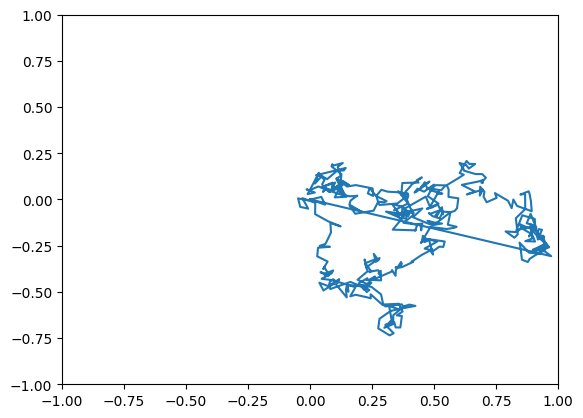

In [176]:
def simulator2DDD(a,mu,sigma,ndt, max_iter=1e5,dt=1e-3):
    """Generates a response time and choice from the LCA model given a set of parameters."""
    x = np.zeros((int(max_iter),2),dtype=float)
    dx = np.zeros(2,dtype=np.float);
    # accumulation process
    num_iter = 0
    while np.linalg.norm(x[num_iter])<a and num_iter < max_iter:
        # iterate over accumulators
        dx = mu*dt + sigma * np.sqrt(dt) * np.random.randn(2)
        x[num_iter+1] = x[num_iter] + dx
        num_iter += 1
    # determine respnose time and choice
    rt = num_iter * dt + ndt
    if num_iter < max_iter:
        resp = float(np.arctan2(x[num_iter,0],x[num_iter,1]))
    else:
        resp = -1.0
    return x, rt, resp
x,r,resp= simulator2DDD(1.0,np.array([1.0,1.0]),1,0)
fig, ax = plt.subplots()
ax.plot(x[:,0],x[:,1])
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
print(r)
print(resp*180/np.pi)

## Prior

In [177]:
def Prior2D():
    drifts = RNG.uniform(-5, 5, size=2)
    threshold = RNG.uniform(0,5)
    ndt = RNG.uniform(0.100, 0.250)
    return np.hstack((threshold, drifts, ndt))

In [178]:
PARAM_NAMES = [
    r"$x-drift$",
    r"$y-drift$",
    r"$threshold$",
    r"$non-decision-time$",

]

In [179]:
prior2D = bf.simulation.Prior(prior_fun=Prior2D,param_names=PARAM_NAMES)

In [180]:
prior2D(batch_size=1)

{'prior_draws': array([[ 2.52070322,  3.96526511, -3.49193312,  0.227708  ]]),
 'batchable_context': None,
 'non_batchable_context': None}

In [181]:
simulator2D = bf.simulation.Simulator(simulator_fun=simulator2DD)

##Generative Model

In [182]:
model = bf.simulation.GenerativeModel(prior=prior2D, simulator=simulator2D, name="2D")

INFO:root:Performing 2 pilot runs with the 2D model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [57]:
out = model(batch_size=3)
out['sim_data'].shape

(3, 10, 2)

##Prior Pushforward Check

RT

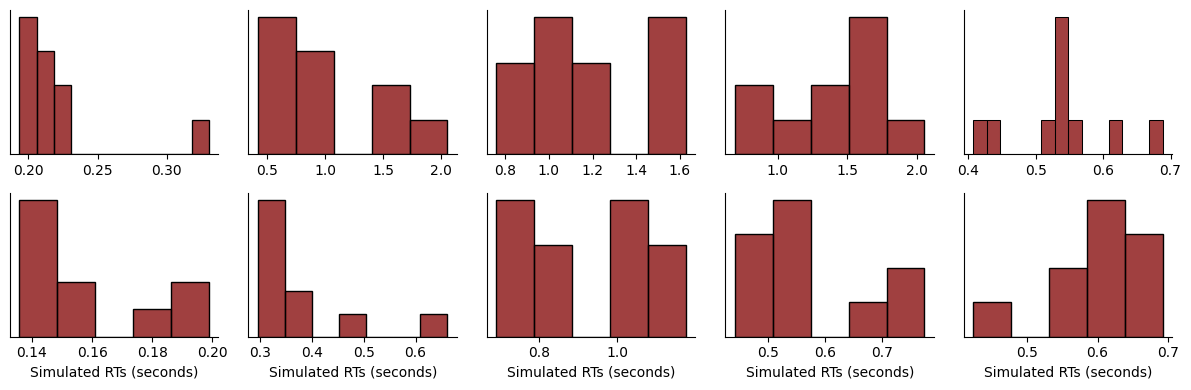

In [58]:
example_sim = model(batch_size=10)
f, axarr = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in enumerate(axarr.flat):
    sns.histplot(example_sim["sim_data"][i, :, 0].flatten(), color="maroon", alpha=0.75, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("")
    ax.set_yticks([])
    if i > 4:
        ax.set_xlabel("Simulated RTs (seconds)")
f.tight_layout()

Response

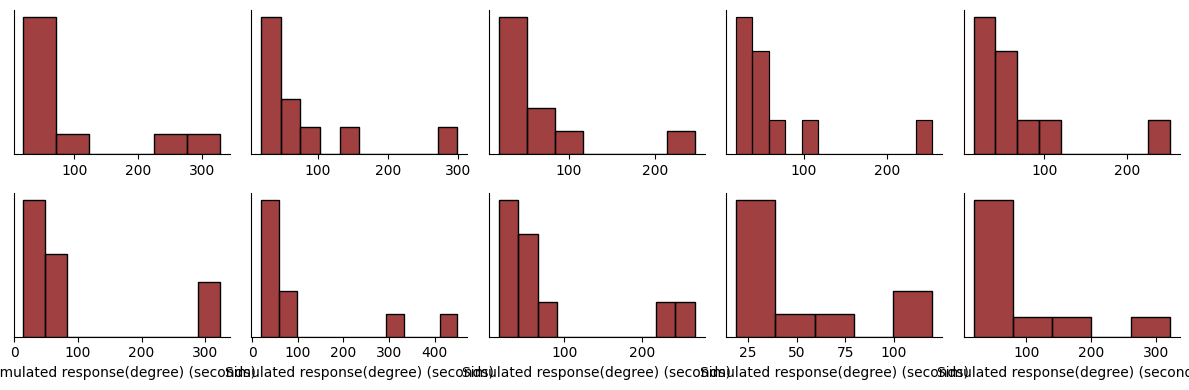

In [59]:
example_sim = model(batch_size=10)
for i in range(0,10):
  x = example_sim["sim_data"][:, i, 0]
  x = x*180/np.pi
  example_sim["sim_data"][:, i, 0] = x
f, axarr = plt.subplots(2, 5, figsize=(12, 4))

for i, ax in enumerate(axarr.flat):
    sns.histplot(example_sim["sim_data"][:, i, 0].flatten(), color="maroon", alpha=0.75, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("")
    ax.set_yticks([])
    if i > 4:
        ax.set_xlabel("Simulated response(degree) (seconds)")
f.tight_layout()

## Summary Network

In [60]:
summary_net = bf.networks.DeepSet(summary_dim=10)

In [61]:
test_inp = model(batch_size=3)
summary_rep = summary_net(test_inp["sim_data"]).numpy()

print("Shape of simulated data sets: ", test_inp["sim_data"].shape)
print("Shape of summary vectors: ", summary_rep.shape)

Shape of simulated data sets:  (3, 10, 2)
Shape of summary vectors:  (3, 10)


##Inference Network

In [62]:
inference_net = bf.networks.InvertibleNetwork(
    num_params=4,
    num_coupling_layers=4,
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
)

##Amortizer

In [63]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

## Test setup

In [64]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [65]:
# Simulate some data again
out = model(3)

print("Keys of simulated dict: ", list(out.keys()))

Keys of simulated dict:  ['prior_non_batchable_context', 'prior_batchable_context', 'prior_draws', 'sim_non_batchable_context', 'sim_batchable_context', 'sim_data']


In [66]:
out

{'prior_non_batchable_context': None,
 'prior_batchable_context': None,
 'prior_draws': array([[ 0.49067561,  3.01098352,  2.76756081,  0.11493123],
        [ 3.29408761, -3.89647773,  2.79267015,  0.19880978],
        [ 1.8784491 ,  0.50105418, -2.77512237,  0.21638733]]),
 'sim_non_batchable_context': None,
 'sim_batchable_context': None,
 'sim_data': array([[[ 0.22693123,  0.30910229],
         [ 0.20693123,  1.3798034 ],
         [ 0.19093123, -0.4191461 ],
         [ 0.15893123,  1.73025065],
         [ 0.20593123,  1.2323591 ],
         [ 0.17693123,  1.41788803],
         [ 0.17893123,  0.10212043],
         [ 0.14393123,  0.75791141],
         [ 0.15493123,  0.14086686],
         [ 0.23093123,  0.69079775]],
 
        [[ 1.13580978, -0.81164104],
         [ 1.10080978, -0.62192134],
         [ 0.60280978, -1.11014457],
         [ 0.77280978, -1.03428052],
         [ 0.83680978, -1.12752262],
         [ 0.84980978, -0.97576122],
         [ 0.70480978, -0.59320223],
         [ 0.

In [67]:
conf_out = trainer.configurator(out)

In [68]:
print(conf_out['parameters'])
print("#####################")
out['prior_draws']

[[ 0.4906756   3.0109835   2.7675607   0.11493123]
 [ 3.2940876  -3.8964777   2.7926702   0.19880977]
 [ 1.8784491   0.50105417 -2.7751224   0.21638733]]
#####################


array([[ 0.49067561,  3.01098352,  2.76756081,  0.11493123],
       [ 3.29408761, -3.89647773,  2.79267015,  0.19880978],
       [ 1.8784491 ,  0.50105418, -2.77512237,  0.21638733]])

In [69]:
print(np.allclose(out["sim_data"], conf_out["summary_conditions"]))
print(np.allclose(out["prior_draws"], conf_out["parameters"]))

True
True


## Train model

In [70]:
amortizer.summary()

Model: "amortized_posterior_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_2 (Inve  multiple                  295008    
 rtibleNetwork)                                                  
                                                                 
 deep_set_2 (DeepSet)        multiple                  67466     
                                                                 
Total params: 362474 (1.38 MB)
Trainable params: 362442 (1.38 MB)
Non-trainable params: 32 (128.00 Byte)
_________________________________________________________________


In [71]:
history = trainer.train_online(epochs=5, iterations_per_epoch=500, batch_size=32, validation_sims=200)


INFO:root:Generated 200 simulations for validation.


Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 1.913


Training epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 0.473


Training epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 0.235


Training epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 0.120


Training epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 0.051


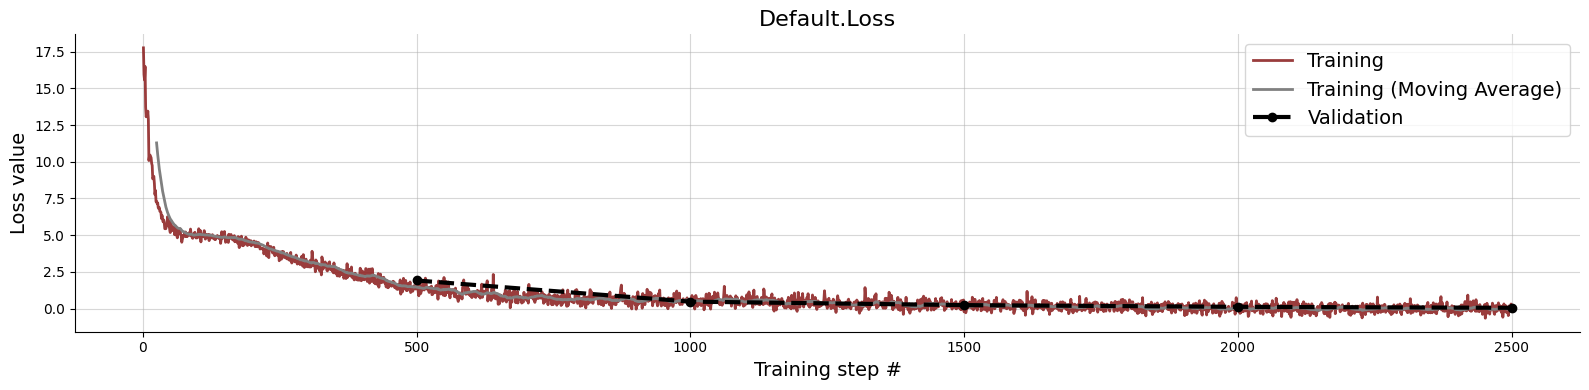

In [73]:
f = bf.diagnostics.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

##Validation

In [ ]:
# Generate some validation data
test_sims = trainer.configurator(model(500))


In [105]:
test_sims['summary_conditions'].shape

(500, 10, 2)

 Latent space inspection

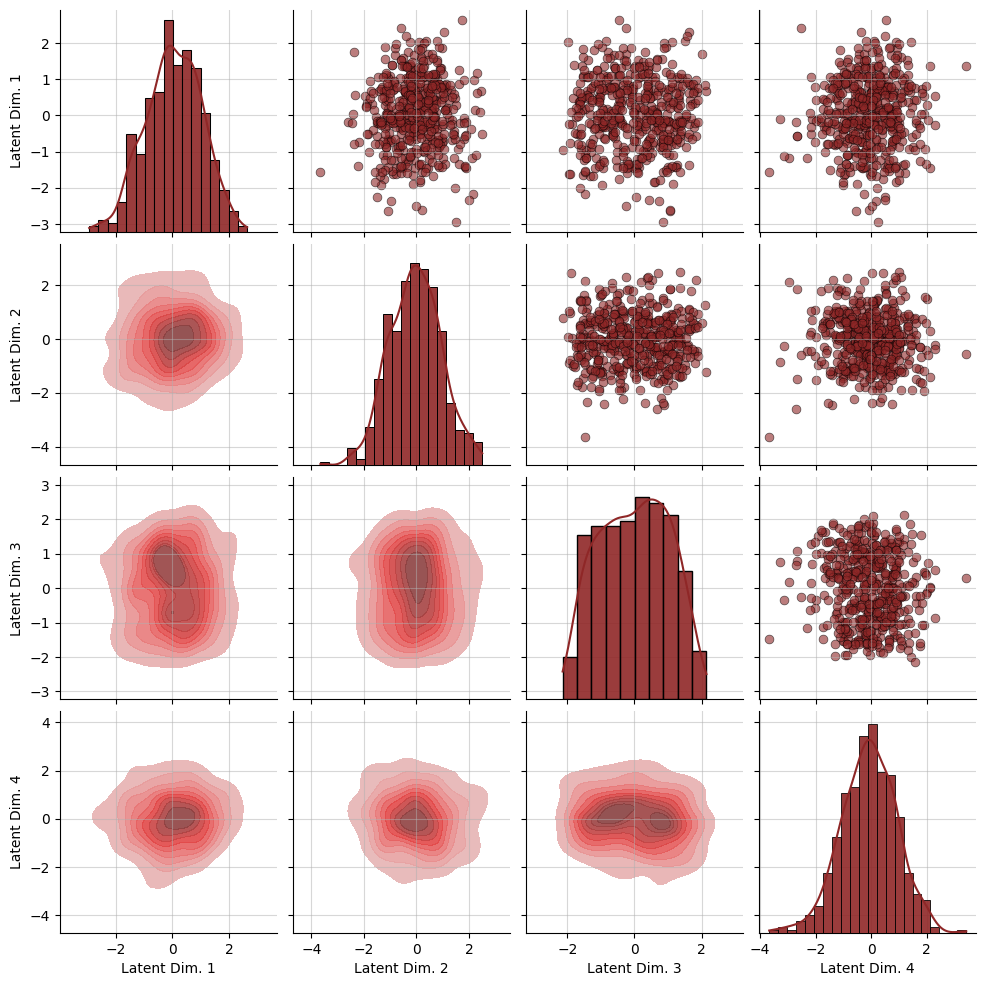

In [101]:
z_samples, _ = amortizer(test_sims)
f = bf.diagnostics.plot_latent_space_2d(z_samples)

Simulation-Based Calibration

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 5.                    Confidence intervals might be unreliable!


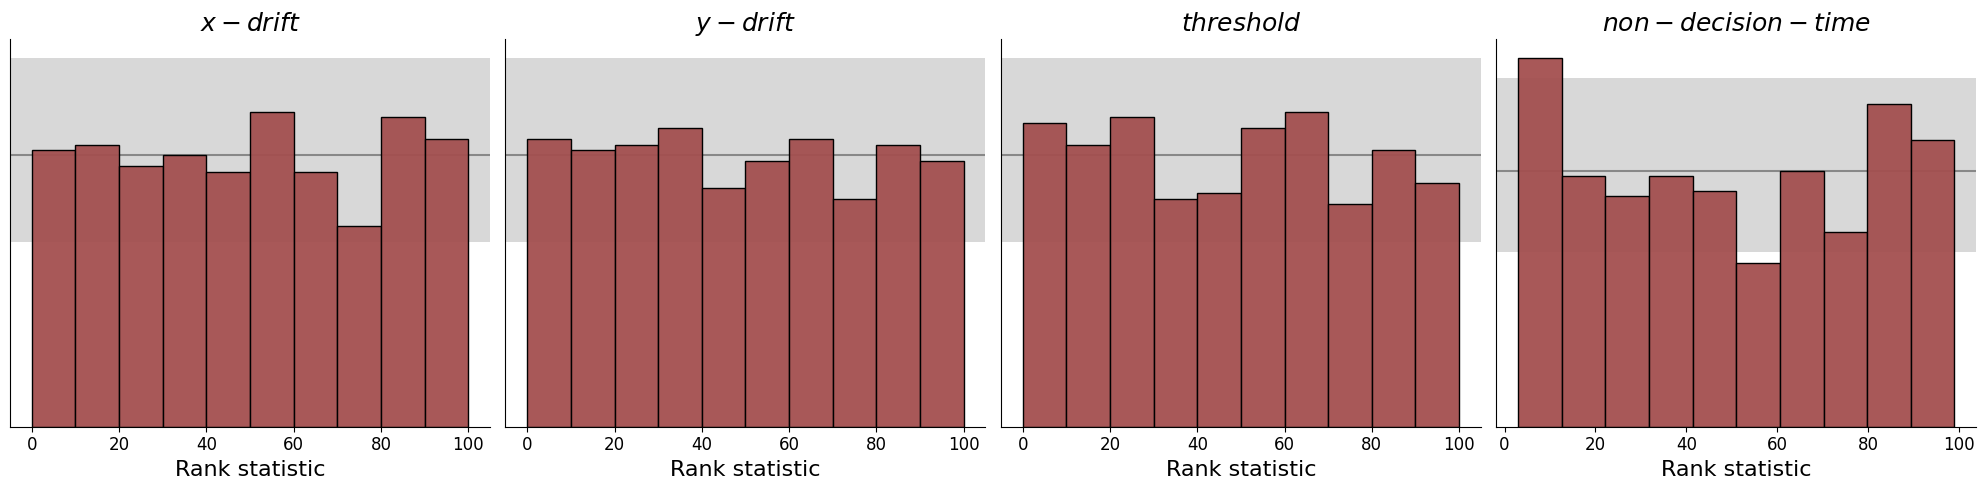

In [109]:
# Obtain 100 posterior samples for each simulated data set in test_sims
posterior_samples = amortizer.sample(test_sims, n_samples=100)
f = bf.diagnostics.plot_sbc_histograms(posterior_samples, test_sims["parameters"], num_bins=10,param_names=PARAM_NAMES)

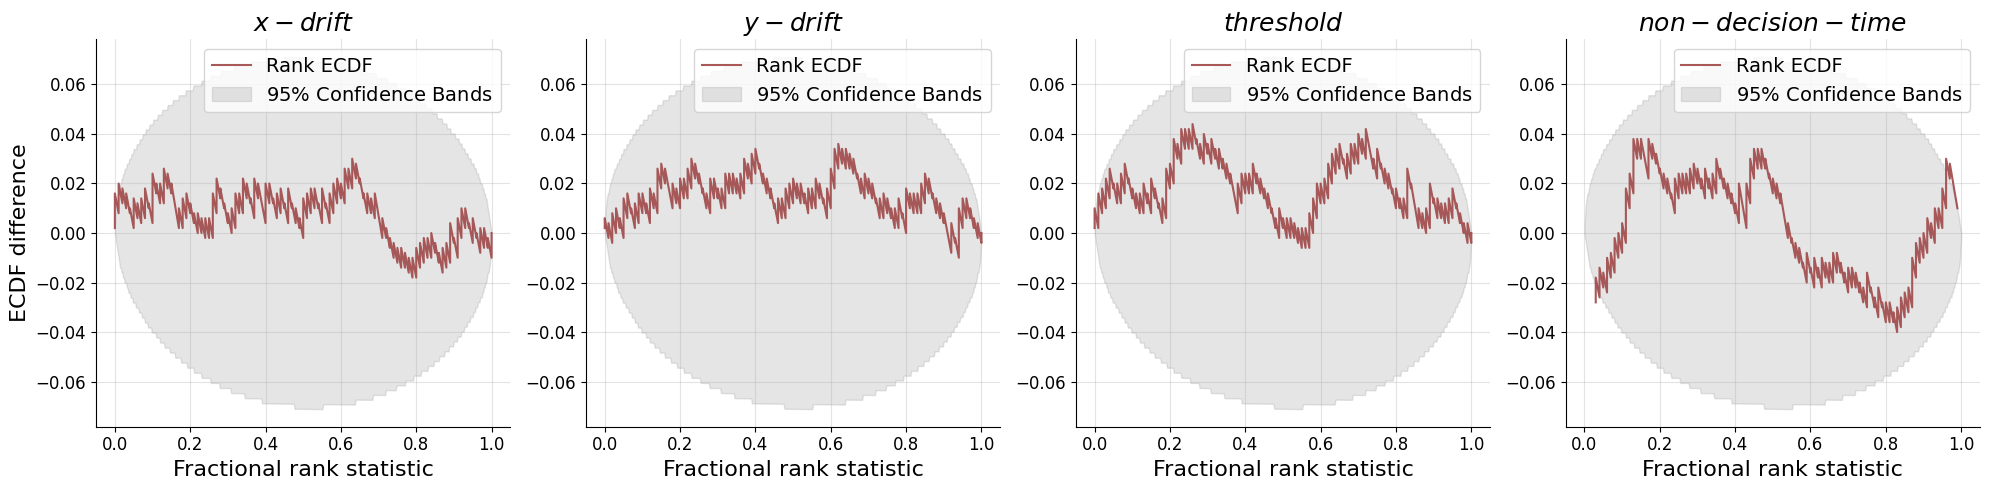

In [111]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, test_sims["parameters"], difference=True,param_names=PARAM_NAMES)

Model Sensitivity

In [112]:
post_samples = amortizer.sample(test_sims, n_samples=1000)


In [113]:
print("Shape of posterior samples array:", post_samples.shape)

Shape of posterior samples array: (500, 1000, 4)


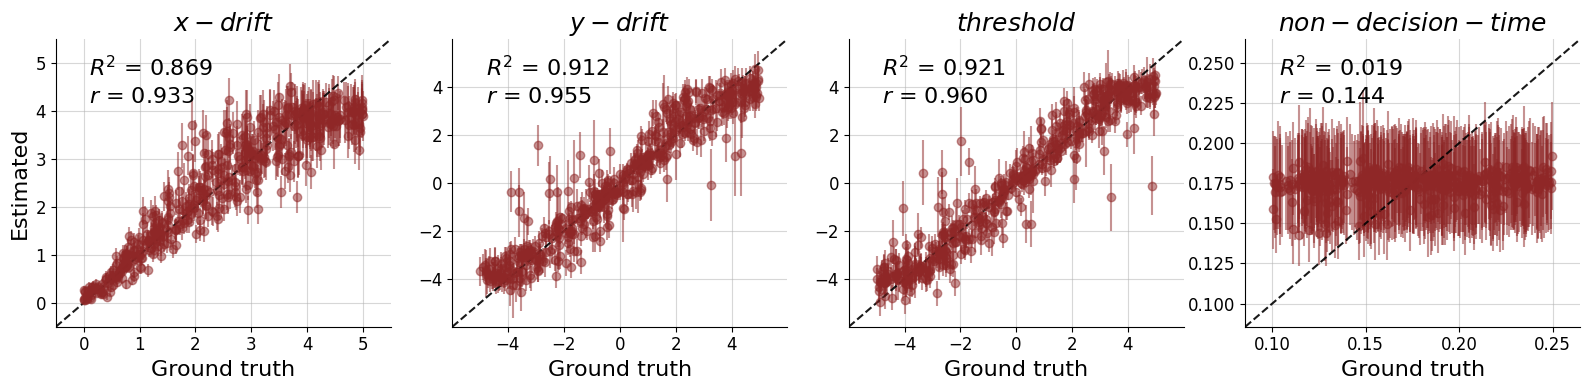

In [114]:
f = bf.diagnostics.plot_recovery(post_samples, test_sims["parameters"],param_names=PARAM_NAMES)

Z Score

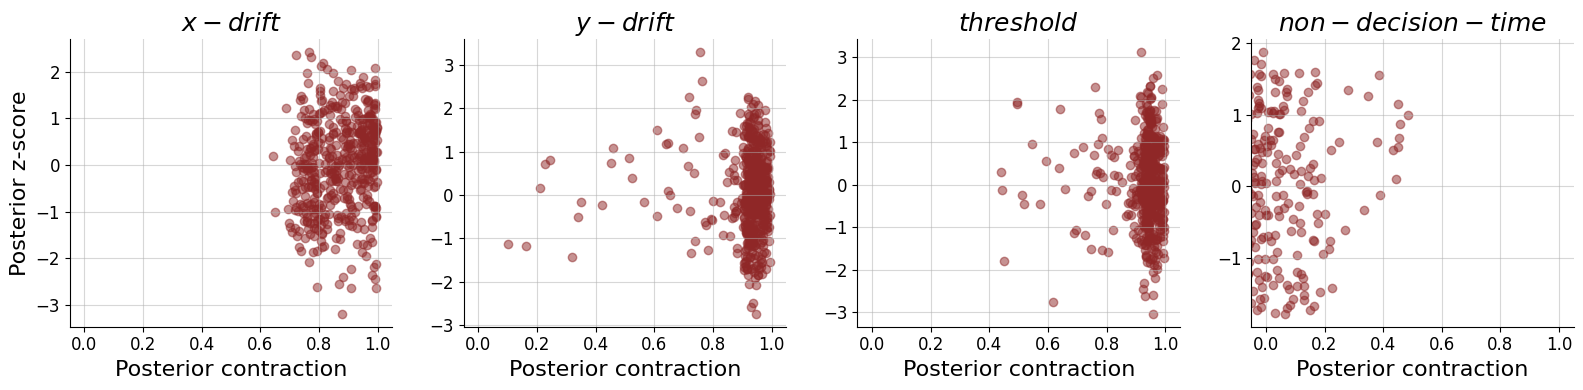

In [115]:
f = bf.diagnostics.plot_z_score_contraction(post_samples, test_sims["parameters"],param_names=PARAM_NAMES)

##Posterior Retrodictive Checks in Silico


1-Simulate data with our generative model.

2-Fit the model to these data.

3-esimulate new data with samples from the obtained posterior.

4-Compare (summary of) the simulated data and the resimulated data (model prediction).

In [116]:
# Define re-simulation settings
num_sim = 8
num_samples = 1000
num_resim = 50

Step 1

In [119]:
# Simulate and configure data
sim_data = model(batch_size=num_sim)
# conf_data = trainer.configurator(sim_data)
conf_data = sim_data
num_obs = sim_data["sim_data"].shape[1]


In [120]:
# Generate some validation data
test_sims = trainer.configurator(model(num_sim))


Step 2

In [121]:
# Fit model -> draw 1000 posterior samples per data set
post_samples = amortizer.sample(test_sims, n_samples=num_samples)
# Unstandardize posteriors draws into original scale
# post_samples_not_z = post_samples * prior_stds + prior_means

In [124]:
post_samples.shape

(8, 1000, 4)

Step 3



In [165]:
# Generate random index for posterior parameter set selection
index_set = np.random.choice(np.arange(num_samples), size=num_resim)

# Get context of simulated data sets
# context = sim_data["sim_batchable_context"]

# Re-simulate
pred_data = np.zeros((num_sim, num_resim, num_obs, 2))
for sim in range(num_sim):
    for i, idx in enumerate(index_set):
        for j in  range(num_obs):
            pred_data[sim, i, j, :] = simulator2DD(post_samples[sim, idx, :], n_object=1)

Step 4

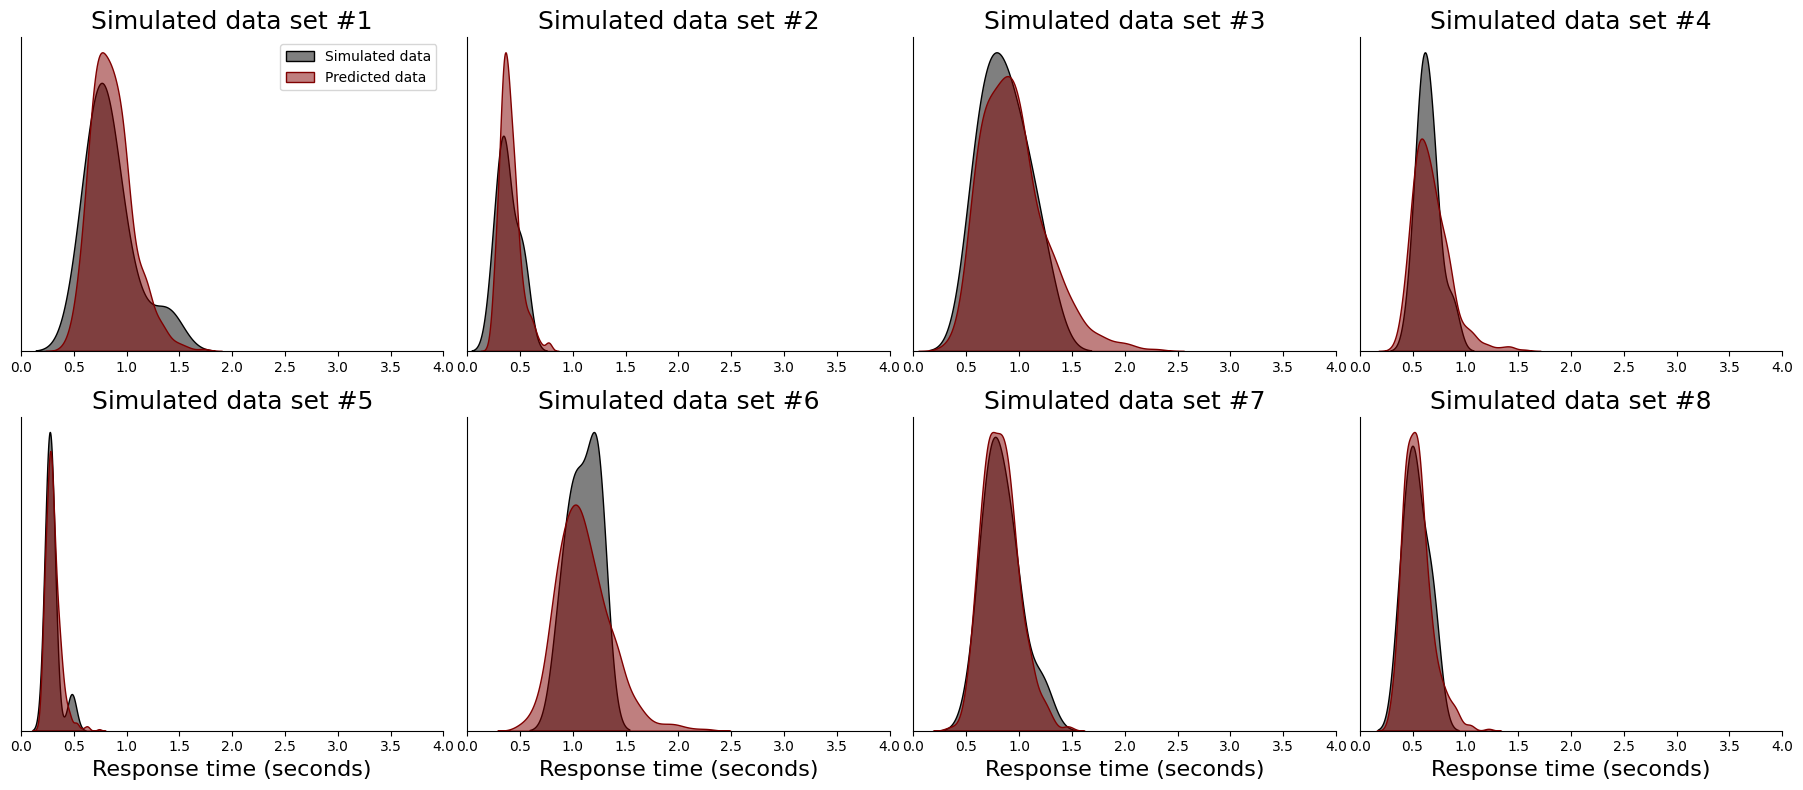

In [167]:
f, axarr = plt.subplots(2, 4, figsize=(18, 8))
for i, ax in enumerate(axarr.flat):
    sns.kdeplot(
        test_sims["summary_conditions"][i, :, 0], ax=ax, fill=True, color="black", alpha=0.5, label="Simulated data"
    )
    sns.kdeplot(pred_data[i, :, :, 0].flatten(), ax=ax, fill=True, color="maroon", alpha=0.5, label="Predicted data")
    ax.set_xlim((0, 4))
    ax.set_ylabel("")
    ax.set_yticks([])
    ax.set_title(f"Simulated data set #{i+1}", fontsize=18)
    # Set legend to first plot
    if i == 0:
        ax.legend()

    # Set x label to bottom row
    if i > (num_sim // 2) - 1:
        ax.set_xlabel("Response time (seconds)", fontsize=16)
    sns.despine()
f.tight_layout()